<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/%5Bfor_Paper%5D_post_graduate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
✅ Check Point
> MaleVis Datasset으로 전이학습 수행<br>
> 우선은 학습을 잘 시켜본다. 학습 결과가 좋다면 해당 분류기를 전이하여 기존의 연구를 발전시킬 수 있다<br>
> 실험을 계속해서 진행하며 기존 연구를 발전시켜보자





## Mount Drive

In [1]:
# mount drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd drive/MyDrive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip\ \(Unzipped\ Files\)/ResNetVAE-master/Post_graduate
! ls

/content/drive/MyDrive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master/Post_graduate
'[for Paper] post graduate.ipynb'   malevis_train_val_224x224.zip   __pycache__
 malevis_train_val_224x224	    modules.py


`malevis_train_val_224x224` 에 학습 데이터와 검증 데이터가 준비되어 있습니다 -20.12.15.Tue. pm12:00

In [4]:
!ls

'[for Paper] post graduate.ipynb'   malevis_train_val_224x224.zip   __pycache__
 malevis_train_val_224x224	    modules.py


## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

# save single numpy array
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data  # torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

# load modules
from torchvision import models
from modules import *

modules 파일을 작업 디렉토리로 옮겨놔야 합니다

## 02. Data Preparation

In [6]:
transforms = transforms.Compose([
                                #  transforms.Resize((224, 224)), # 이미 224x224로 되어있기에 생략해도 될 듯 하다 -20.12.15.Tue-
                                 transforms.Grayscale(num_output_channels=3),  # for transfer learning
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std = [0.229, 0.224, 0.225])
                                ])

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='./malevis_train_val_224x224/train',
                                            transform = transforms)
valset = torchvision.datasets.ImageFolder(root='./malevis_train_val_224x224/val',
                                          transform = transforms)

In [7]:
classes = trainset.classes
classes

['Adposhel',
 'Agent',
 'Allaple',
 'Amonetize',
 'Androm',
 'Autorun',
 'BrowseFox',
 'Dinwod',
 'Elex',
 'Expiro',
 'Fasong',
 'HackKMS',
 'Hlux',
 'Injector',
 'InstallCore',
 'MultiPlug',
 'Neoreklami',
 'Neshta',
 'Other',
 'Regrun',
 'Sality',
 'Snarasite',
 'Stantinko',
 'VBA',
 'VBKrypt',
 'Vilsel']

In [8]:
malimg_class = ['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [10]:
for idx, cls in enumerate(classes):
    if cls in malimg_class:
        print(cls)

check point. 기존의 데이터와 같은 패밀리를 같는 데이터는 단 하나도 없구나!

Split, train data to train, val, test

In [11]:
full_dataset = trainset

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = int(len(full_dataset) - train_size - val_size)

print("train_size, val_size, test_size: ", train_size, val_size, test_size)

train_size, val_size, test_size:  7280 910 910


In [13]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
print("train_dataset, val_dataset, test_dataset: ", len(train_dataset), len(val_dataset), len(test_dataset))

train_dataset, val_dataset, test_dataset:  7280 910 910


In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=16,
                                         shuffle=True,
                                         pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=16,
                                          shuffle=True, 
                                          pin_memory=True)

In [17]:
# For 3-Channel Image print

print_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True)

In [18]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape

In [20]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([12,  7, 19, 24,  3, 16, 17, 11,  9, 13, 14, 13,  6, 18, 15,  3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 3, 224, 224])
torch.Size([3, 454, 1810])
 Hlux Dinwod Regrun VBKrypt Amonetize Neoreklami Neshta HackKMS Expiro Injector InstallCore Injector BrowseFox Other MultiPlug Amonetize 


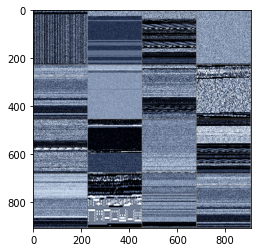

In [21]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))


## 03. Model Architecture